In [5]:
!pip install beautifulsoup4


In [590]:
import requests 
from bs4 import BeautifulSoup
import pandas as pd
import re
import urllib.parse
import matplotlib.pyplot as plt

In [705]:
df = pd.read_csv("ffkkmo_dump.csv")

In [716]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23749 entries, 0 to 24716
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   23749 non-null  int64  
 1   title        23749 non-null  object 
 2   date         23749 non-null  object 
 3   place        23749 non-null  object 
 4   online_link  23749 non-null  object 
 5   category     23749 non-null  object 
 6   rank         23749 non-null  int64  
 7   name         23749 non-null  object 
 8   club         23749 non-null  object 
 9   points       23749 non-null  float64
dtypes: float64(1), int64(2), object(7)
memory usage: 2.5+ MB


In [717]:
df = df.drop(df[df['rank'].isin(['WD', 'FNR', 'DSQ', '0'])].index)
df['rank'] = df['rank'].astype('int64')
df['points'] = df['points'].astype('float')
df['date'] = df['date'].str.strip()
df['date'] = pd.to_datetime(df['date'], format='%d.%m.%Y')

In [718]:
def replace_duplicates(df, keyword, name):
    uniquenames = [ s for s in df.club.unique() if keyword.findall(str(s).lower()) ]
    return df['club'].replace(uniquenames, name)

In [720]:
def get_regex_club(city, club):
    return re.compile((r"(" + club + ")(?s:.*?)(" + city + ")|(" + city + ")(?s:.*?)(" + club + ")").lower())

In [743]:
[ s for s in df.club.unique() if get_regex_club('Павлов', '').findall(str(s).lower()) ]

['г.о. Павловский Посад, МУДО ДЮСШ',
 'г.о Павловский-Посад, МУДО СШ',
 'г.о. Павлово-Посадсий, МУДО СШ',
 'г.о. Павловский-Посад, МУДО СШ',
 'г.о. Павлово-Посадский,  МУДО СШ',
 'г.о.Павлово – Посадский, МУДО СШ',
 'г.о. Павлово-Посадский, МУДО СШ',
 'г.о. Павлово-Посадский, МУ ДО Ленский стадион',
 'МУДО СШ г.о.Павлово-Посадский',
 'МУДО СШ г.о.Павлово - Посадский']

In [742]:
len(df['club'].unique())

133

In [744]:
df['club'] = replace_duplicates(df, get_regex_club('', 'Ляпкина'), 'г.о. Балашиха, МАУ ДО «СШОР им. Ю.Е. Ляпкина»')
df['club'] = replace_duplicates(df, get_regex_club('', 'Ляпкна'), 'г.о. Балашиха, МАУ ДО «СШОР им. Ю.Е. Ляпкина»')
df['club'] = replace_duplicates(df, get_regex_club('', 'Голден'), 'г.о. Балашиха, СКФК «Голден Стар»')
df['club'] = replace_duplicates(df, get_regex_club('Балашиха', 'Олимп'), "г.о. Балашиха, АНО ДЮСШ «Олимп»")
df['club'] = replace_duplicates(df, get_regex_club('Мытищи', 'Авангард'), 'г.о. Мытищи, МБУ ДО «СШ «Авангард»')
df['club'] = replace_duplicates(df, get_regex_club('Королев', 'Варяг'), 'г. Королев, СК «Варяг»')
df['club'] = replace_duplicates(df, get_regex_club('Королёв', 'Варяг'), 'г. Королев, СК «Варяг»')
df['club'] = replace_duplicates(df, get_regex_club('Королев', 'Спортивн'), 'г. Королев, МБУ «Спортивные Сооружения»')
df['club'] = replace_duplicates(df, get_regex_club('Королёв', 'Спортивн'), 'г. Королев, МБУ «Спортивные Сооружения»')
df['club'] = replace_duplicates(df, get_regex_club('', 'Наши Надежды'), 'г.о. Красногорск, АНО ДО АФК «Наши Надежды»')
df['club'] = replace_duplicates(df, get_regex_club('', 'пахом'), 'г.о. Химки, АНО ДО «СШФК памяти Л.А. Пахомовой»')
df['club'] = replace_duplicates(df, get_regex_club('Наро-Фоминск', 'СШ'), 'г.о. Наро-Фоминский, МАУ ДО ЦСШ №1')
df['club'] = replace_duplicates(df, get_regex_club('Наро-Фоминск', 'Галактика'), 'г.о. Наро-Фоминск, ООО СКФК «Галактика»')
df['club'] = replace_duplicates(df, get_regex_club('Красногорск', 'Давыдов'), 'г.о. Красногорск, ИП Давыдов')
df['club'] = replace_duplicates(df, get_regex_club('Красногорск', 'КСШОР'), 'г.о. Красногорск, МБУ КСШОР "Зоркий"')
df['club'] = replace_duplicates(df, get_regex_club('', 'Зоркий'), 'г.о. Красногорск, МБУ КСШОР "Зоркий"')
df['club'] = replace_duplicates(df, get_regex_club('Красногорск', 'Снежком'), 'г.о. Красногорск, ЦФМ «Снежком»')
df['club'] = replace_duplicates(df, get_regex_club('Красногорск', 'Снеж.ком'), 'г.о. Красногорск, ЦФМ «Снежком»')
df['club'] = replace_duplicates(df, get_regex_club('Красногорск', 'ЦФМ'), 'г.о. Красногорск, ЦФМ «Снежком»')
df['club'] = replace_duplicates(df, get_regex_club('Красногорск', 'DAVYDOV'), 'г.о. Красногорск, START TEAM DAVYDOV')
df['club'] = replace_duplicates(df, get_regex_club('Красногорск', 'Козачинский'), 'г.о. Красногорск, ИП Козачинский')
df['club'] = replace_duplicates(df, get_regex_club('Красногорск', 'Вербилло'), 'г.о. Красногорск, ИП Вербилло')
df['club'] = replace_duplicates(df, get_regex_club('Красногорск', 'Вербило'), 'г.о. Красногорск, ИП Вербилло')
df['club'] = replace_duplicates(df, get_regex_club('Красногорск', 'Путь к успеху'), 'г.о. Красногорск, Союз МС Школа «Путь к успеху»')
df['club'] = replace_duplicates(df, get_regex_club('Красногорск', 'Эдвайс'), 'г.о. Красногорск, «ООО НК Эдвайс»')
df['club'] = replace_duplicates(df, get_regex_club('Люберцы', 'КСШОР'), 'г.о. Люберцы, МУДО КСШОР')
df['club'] = replace_duplicates(df, get_regex_club('Люберцы', 'Армия'), "г.о. Люберцы, СК «Армия фигурного катания»")
df['club'] = replace_duplicates(df, get_regex_club('Лыткарино', ''), "г.о. Лыткарино, МАУ «ЛСК Лыткарино»")
df['club'] = replace_duplicates(df, get_regex_club('Ступино', 'Боброва'), "г. Ступино, МБУ ДО «СШОР им. В.Б. Боброва»")
df['club'] = replace_duplicates(df, get_regex_club('Щелково', ''), "г.о. Щелково, МАУ ГОЩ «ФОК «Ледовая арена» им. В.А. Третьяка")
df['club'] = replace_duplicates(df, get_regex_club('Щёлково', ''), "г.о. Щелково, МАУ ГОЩ «ФОК «Ледовая арена» им. В.А. Третьяка")
df['club'] = replace_duplicates(df, get_regex_club('Подольск', 'Витязь'), "г.о. Подольск, МУ ДО СШОР «Витязь»")
df['club'] = replace_duplicates(df, get_regex_club('Подольск', 'Арена'), "г.о. Подольск, ШФК «Арена»")
df['club'] = replace_duplicates(df, get_regex_club('Подольск', 'Слуцкой'), "г.о. Подольск, ШФК Слуцкой")
df['club'] = replace_duplicates(df, get_regex_club('Чехов', 'Витязь'), "г.о. Чехов, МАУ «СШ «Витязь» им. В.И. Васильева")
df['club'] = replace_duplicates(df, get_regex_club('Чехов', 'Спарта'), "МАУ «СШ «Спарта»")
df['club'] = replace_duplicates(df, get_regex_club('', 'СЛУ-ГРУПП'), "г.о. Подольск, ООО «СЛУ-ГРУПП»")
df['club'] = replace_duplicates(df, get_regex_club('', 'Заречье'), "п. Заречье, ДЮСШ фигурного катания Ирины Слуцкой")
df['club'] = replace_duplicates(df, get_regex_club('', 'Лидер'), "г.о. Ивантеевка, МАУ ДО «СШ «Лидер»")
df['club'] = replace_duplicates(df, get_regex_club('', 'Салют'), "г.о. Долгопрудный, АУ «ФСК-Салют»")
df['club'] = replace_duplicates(df, get_regex_club('', 'альфа'), "г.о. Долгопрудный, СК «Альфа»")
df['club'] = replace_duplicates(df, get_regex_club('', 'Смирнова'), "г.о. Долгопрудный, АНО ДО СШФК «Смирнова Тим»")
df['club'] = replace_duplicates(df, get_regex_club('Клин', ''), "г. Клин, МБУ ДО СШОР «Клин спортивный»")
df['club'] = replace_duplicates(df, get_regex_club('Реутов', ''), "г.о. Реутов, Центр хоккея и фигурного катания «Айс Про»")
df['club'] = replace_duplicates(df, get_regex_club('', 'Айс Про'), "г.о. Реутов, Центр хоккея и фигурного катания «Айс Про»")
df['club'] = replace_duplicates(df, get_regex_club('', 'Ангелы'), "г.о. Одинцово, ООО «АФК «Ангелы Плющенко»")
df['club'] = replace_duplicates(df, get_regex_club('Одинцово', 'СШ'), "г.о. Одинцово, МБУ ДО СШ «Одинцово»")
df['club'] = replace_duplicates(df, get_regex_club('Одинцово', 'МБУС'), "г.о. Одинцово, МБУ ДО СШ «Одинцово»")
df['club'] = replace_duplicates(df, get_regex_club('Лобня', 'ЦФК'), "г.о. Лобня, МБУ «ЦФКиС»")
df['club'] = replace_duplicates(df, get_regex_club('Лобня', 'Дети'), "г.о. Лобня, СК ФК «Дети – наше будущее»")
df['club'] = replace_duplicates(df, get_regex_club('Лобня', 'Центр'), "г.о. Лобня, МБУ «ЦФКиС»")
df['club'] = replace_duplicates(df, get_regex_club('Лобня', 'УФК'), "г.о. Лобня, МБУ «ЦФКиС»")
df['club'] = replace_duplicates(df, get_regex_club('г.Лобня', ''), "г.о. Лобня, МБУ «ЦФКиС»")
df['club'] = replace_duplicates(df, get_regex_club('', 'Арктика'), 'г.о. Ленинский, АНО «ЦОСБЛ и ТК»')
df['club'] = replace_duplicates(df, get_regex_club('Видное', 'Центр'), "г.о. Ленинский, ООО «Центр спортивных технологий»")
df['club'] = replace_duplicates(df, get_regex_club('Видное', 'ЦСТ'), "г.о. Ленинский, ООО «Центр спортивных технологий»")
df['club'] = replace_duplicates(df, get_regex_club('Ленинский', 'ЦСТ'), "г.о. Ленинский, ООО «Центр спортивных технологий»")
df['club'] = replace_duplicates(df, get_regex_club('Ленинский', 'Центр'), "г.о. Ленинский, ООО «Центр спортивных технологий»")
df['club'] = replace_duplicates(df, get_regex_club('Видное', 'ЦОСБЛ'), "г.о. Ленинский, АНО «ЦОСБЛ и ТК»")
df['club'] = replace_duplicates(df, get_regex_club('Ленинский', 'ЦОСБЛ'), "г.о. Ленинский, АНО «ЦОСБЛ и ТК»")
df['club'] = replace_duplicates(df, get_regex_club('Можайск', ''), "г.о. Можайск, МУ «МДС «Багратион»")
df['club'] = replace_duplicates(df, get_regex_club('Электросталь', 'Стальной'), "г. Электросталь, СКФК «Стальной конек»")
df['club'] = replace_duplicates(df, get_regex_club('', 'Стальной конек'), "г. Электросталь, СКФК «Стальной конек»")
df['club'] = replace_duplicates(df, get_regex_club('', 'Кристалл'), "г. Электросталь, МБУДО «СШОР «Кристалл-Восток»")
df['club'] = replace_duplicates(df, get_regex_club('', 'ВОСТОК'), "г. Электросталь, МБУДО «СШОР «Кристалл-Восток»")
df['club'] = replace_duplicates(df, get_regex_club('Электросталь', 'ангел'), "г. Электросталь, ООО «КФК «Ледяной ангел»")
df['club'] = replace_duplicates(df, get_regex_club('Электросталь', 'Мартынова'), "г. Электросталь, ИП Мартынова")
df['club'] = replace_duplicates(df, get_regex_club('Селятино', 'Юность'), "п. Селятино, МАУ СШ №2 «Юность»")
df['club'] = replace_duplicates(df, get_regex_club('Раменское', ''), "г.о. Раменское, МБУ ДО «СШ «Раменское»")
df['club'] = replace_duplicates(df, get_regex_club('Люберцы', 'ХРУСТАЛЬНЫЙ'), "г.о. Люберцы, ООО «Хрустальный лёд»")
df['club'] = replace_duplicates(df, get_regex_club('Серги', 'Центр'), "г.о. Сергиев Посад, МБУ ДО СШ «Центр»")
df['club'] = replace_duplicates(df, get_regex_club('Серги', 'ХРУСТАЛЬНЫЙ ЛЁД'), "г.о. Сергиев Посад, ООО «Хрустальный лед»")
df['club'] = replace_duplicates(df, get_regex_club('Серги', 'ХРУСТАЛЬНЫЙ ЛеД'), "г.о. Сергиев Посад, ООО «Хрустальный лед»")
df['club'] = replace_duplicates(df, get_regex_club('Серги', 'Стремление'), "г.о. Сергиев Посад, ООО «Стремление»")
df['club'] = replace_duplicates(df, get_regex_club('Домодедово', 'Спицын'), "г.о. Домодедово, ИП Спицин")
df['club'] = replace_duplicates(df, get_regex_club('Домодедово', 'Спицин'), "г.о. Домодедово, ИП Спицин")
df['club'] = replace_duplicates(df, get_regex_club('Домодедово', 'Авангард'), "г.о. Домодедово, МАУ «ГС «Авангард»")
df['club'] = replace_duplicates(df, get_regex_club('Домодедово', 'Бестемьяновой'), "г.о. Домодедово, ШФК Натальи Бестемьяновой")
df['club'] = replace_duplicates(df, get_regex_club('Коломна', 'Комета'), "г.о. Коломна, МБУ ДО СШОР «Комета»")
df['club'] = replace_duplicates(df, get_regex_club('Жуковский', 'Метеор'), "г.о. Жуковский, МБУ ДО «СШ – Центр спорта «Метеор»")
df['club'] = replace_duplicates(df, get_regex_club('Дмитров', 'Демченко'), "г.о. Дмитровский, МУ ДО «СШОР Альберта Демченко»")
df['club'] = replace_duplicates(df, get_regex_club('Дмитров', 'Карпенко'), "г.о. Дмитровский, ИП Карпенко")
df['club'] = replace_duplicates(df, get_regex_club('Павлов', ''), "г.о. Павловский Посад, МУДО ДЮСШ")
df['club'] = replace_duplicates(df, get_regex_club('Серпухов', 'Спартак'), "г. Серпухов, МАУ Стадион «Спартак»")
df['club'] = replace_duplicates(df, get_regex_club('Серпухов', 'Золотой'), "г. Серпухов, СКФК «Золотой Конёк»")
df['club'] = replace_duplicates(df, get_regex_club('Серпухов', 'Благова'), "г.Серпухов, АНО АФК им. Василия Благова")
df['club'] = replace_duplicates(df, get_regex_club('Химки', 'ЗВС'), "г.о. Химки, МАУ ДО «СШ ЗВС»")
df['club'] = replace_duplicates(df, get_regex_club('Химки', 'Бородул'), "г.о. Химки, СКФК Бородулиных")
df['club'] = replace_duplicates(df, get_regex_club('Ногинск', ''), "г. Ногинск, МБУ «СШОР»")
df['club'] = replace_duplicates(df, get_regex_club('Шаховская', ''), "г.о. Шаховская, МАУ «Шаховской ДОК»")
df['club'] = replace_duplicates(df, get_regex_club('', 'Алмазный'), "г.о. Подольск, СЦ «Алмазный лед МО»")
df['club'] = replace_duplicates(df, get_regex_club('Малаховка', ''), "г.о. Люберцы, СК «МГАФК - Малаховка»")
df['club'] = replace_duplicates(df, get_regex_club('Орехово', ''), "г. Орехово-Зуево, МУДО «СШ «Спартак Орехово»")





# df['club'] = replace_duplicates(df, get_regex_club('', ''), "")

len(df['club'].unique())

124

In [860]:
year = 2024

In [848]:
def get_top_df(df, column, qty):
    df1 = df['club'].value_counts()
    others = df1[qty:].sum()
    df1 = df1[:qty]
    df1['Остальные'] = others
    return df1

In [866]:
df[(df['year'] == year) & (df['club'] == "п. Заречье, ДЮСШ фигурного катания Ирины Слуцкой")]

,Unnamed: 0,title,date,place,online_link,category,rank,name,club,points,year
18756,9,Спортивные соревнования Московской области по ...,2024-01-27,г. Лыткарино ул. Советская д.9 ЛСК «Лыткарино»,http://ffkkmo.ru/events/2324/lytkarino01/,"3 юношeский рaзряд, дeвочки",10,Мария РУДИК,"п. Заречье, ДЮСШ фигурного катания Ирины Слуцкой",9.30,2024
18766,19,Спортивные соревнования Московской области по ...,2024-01-27,г. Лыткарино ул. Советская д.9 ЛСК «Лыткарино»,http://ffkkmo.ru/events/2324/lytkarino01/,"2 юношeский рaзряд, дeвочки",10,Антонина СКЛЯР,"п. Заречье, ДЮСШ фигурного катания Ирины Слуцкой",19.82,2024
18769,22,Спортивные соревнования Московской области по ...,2024-01-27,г. Лыткарино ул. Советская д.9 ЛСК «Лыткарино»,http://ffkkmo.ru/events/2324/lytkarino01/,"1 юношeский рaзряд, мaльчики",1,Кирилл ГАЛКИН,"п. Заречье, ДЮСШ фигурного катания Ирины Слуцкой",39.27,2024
18771,24,Спортивные соревнования Московской области по ...,2024-01-27,г. Лыткарино ул. Советская д.9 ЛСК «Лыткарино»,http://ffkkmo.ru/events/2324/lytkarino01/,"1 юношeский рaзряд, дeвочки",1,Ксения БОЧКАРЁВА,"п. Заречье, ДЮСШ фигурного катания Ирины Слуцкой",38.42,2024
18772,25,Спортивные соревнования Московской области по ...,2024-01-27,г. Лыткарино ул. Советская д.9 ЛСК «Лыткарино»,http://ffkkmo.ru/events/2324/lytkarino01/,"1 юношeский рaзряд, дeвочки",2,Евдокия ЕРЕМЕЕВА,"п. Заречье, ДЮСШ фигурного катания Ирины Слуцкой",36.89,2024
...,...,...,...,...,...,...,...,...,...,...,...
20394,56,Спортивные соревнования Московской области по ...,2024-04-16,"Наро-Фоминский г.о., пос. Селятино, ЛД ""Селятино""",http://ffkkmo.ru/events/2324/selyatino04/,"2 юнoшecкий рaзряд, мaльчики",1,Павел РАГУЛИН,"п. Заречье, ДЮСШ фигурного катания Ирины Слуцкой",23.82,2024
20418,80,Спортивные соревнования Московской области по ...,2024-04-16,"Наро-Фоминский г.о., пос. Селятино, ЛД ""Селятино""",http://ffkkmo.ru/events/2324/selyatino04/,"3 cпoртивный рaзряд, дeвочки",6,Мария КАРГИНА,"п. Заречье, ДЮСШ фигурного катания Ирины Слуцкой",36.43,2024
20438,100,Спортивные соревнования Московской области по ...,2024-04-16,"Наро-Фоминский г.о., пос. Селятино, ЛД ""Селятино""",http://ffkkmo.ru/events/2324/selyatino04/,"3 cпoртивный рaзряд, мальчики",1,Кирилл ГАЛКИН,"п. Заречье, ДЮСШ фигурного катания Ирины Слуцкой",36.38,2024
20466,8,Спортивные соревнования Московской области по ...,2024-04-20,"г.о. Клин, ул. Карла Маркса, д. 99, Ледовый дв...",http://ffkkmo.ru/events/2324/klin04/,"2 юнoшeский разряд, мaльчики",1,Павел РАГУЛИН,"п. Заречье, ДЮСШ фигурного катания Ирины Слуцкой",26.35,2024


Text(0, 0.5, '')

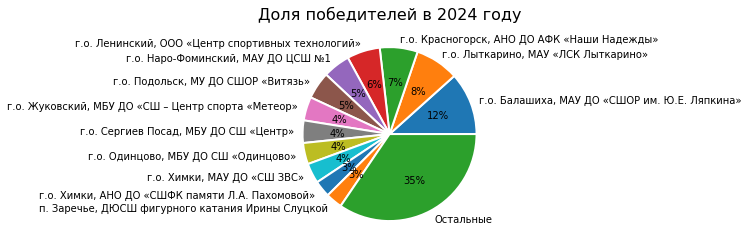

In [863]:
get_top_df(df[(df['year'] == year) & (df['rank'] == 1)], 'club', 12).plot.pie(
    autopct='%1.f%%', 
    legend=False,
    wedgeprops = {"edgecolor" : "white", 
                  'linewidth': 2,
                  'antialiased': True});
plt.title(f'Доля победителей в {year} году', fontsize=16)
plt.xlabel('', fontsize=18)
plt.ylabel('', fontsize=18)

In [770]:
top_clubs = list(df[df['year'] == year].groupby('club').count().sort_values(by='title', ascending=False)['title'].head(3).index)

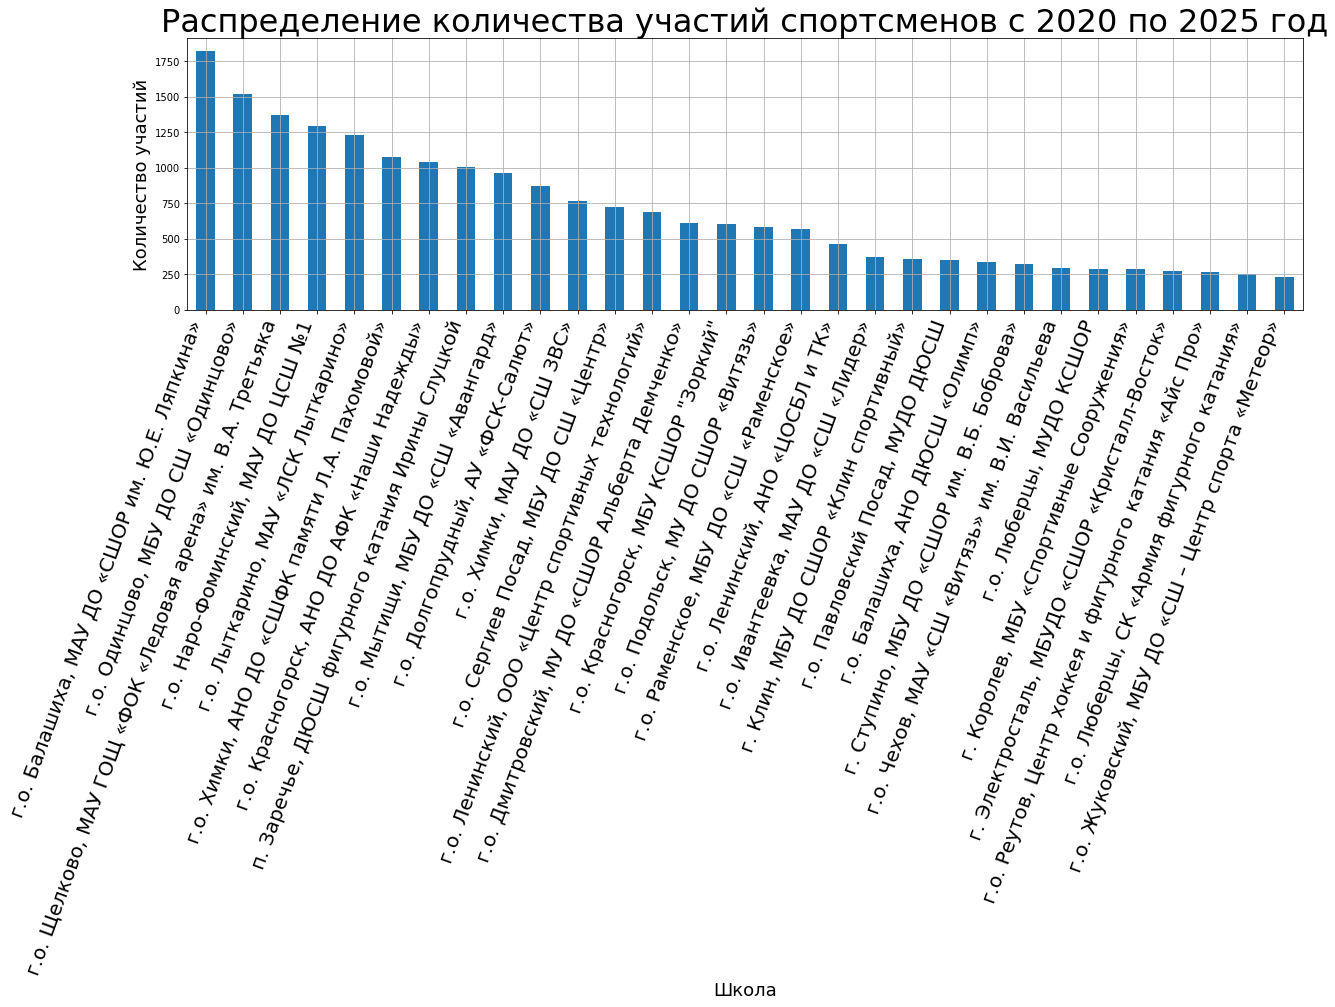

In [727]:
df.groupby('club').count().sort_values(by='title', ascending=False)['title'].head(30).plot(
    kind='bar', figsize=(20, 5), grid=True
)
plt.title('Распределение количества участий спортсменов с 2020 по 2025 год', fontsize=32)
plt.xlabel('Школа', fontsize=18)
plt.ylabel('Количество участий', fontsize=18)
plt.xticks(fontsize=20, rotation=70, horizontalalignment='right');

In [728]:
df['year'] = df['date'].dt.year

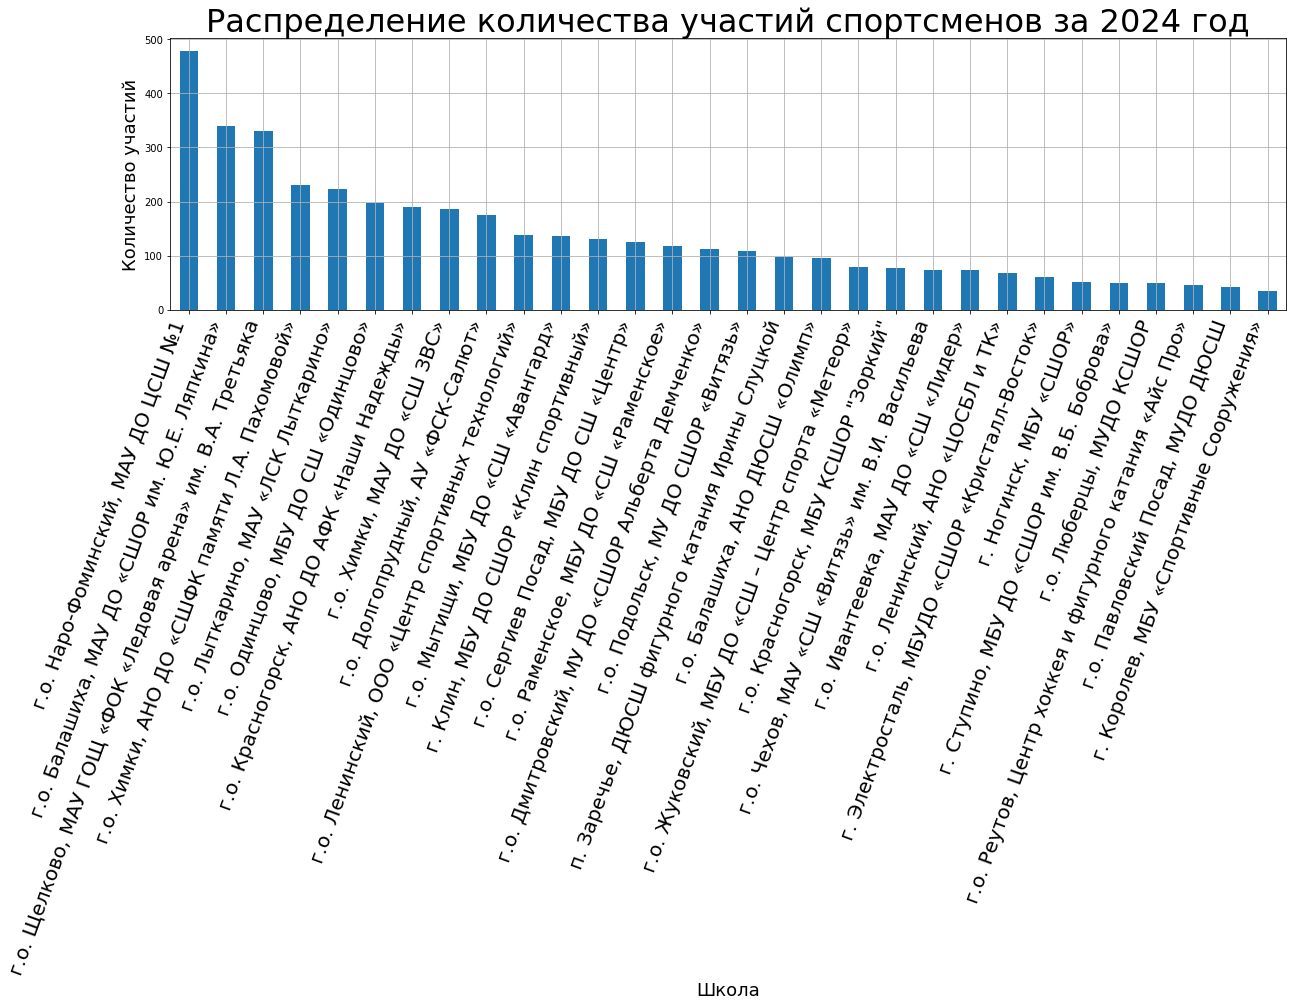

In [730]:
df[df['year'] == 2024].groupby('club').count().sort_values(by='title', ascending=False)['title'].head(30).plot(
    kind='bar', figsize=(20, 5), grid=True
)
plt.title('Распределение количества участий спортсменов за 2024 год', fontsize=32)
plt.xlabel('Школа', fontsize=18)
plt.ylabel('Количество участий', fontsize=18)
plt.xticks(fontsize=20, rotation=70, horizontalalignment='right');

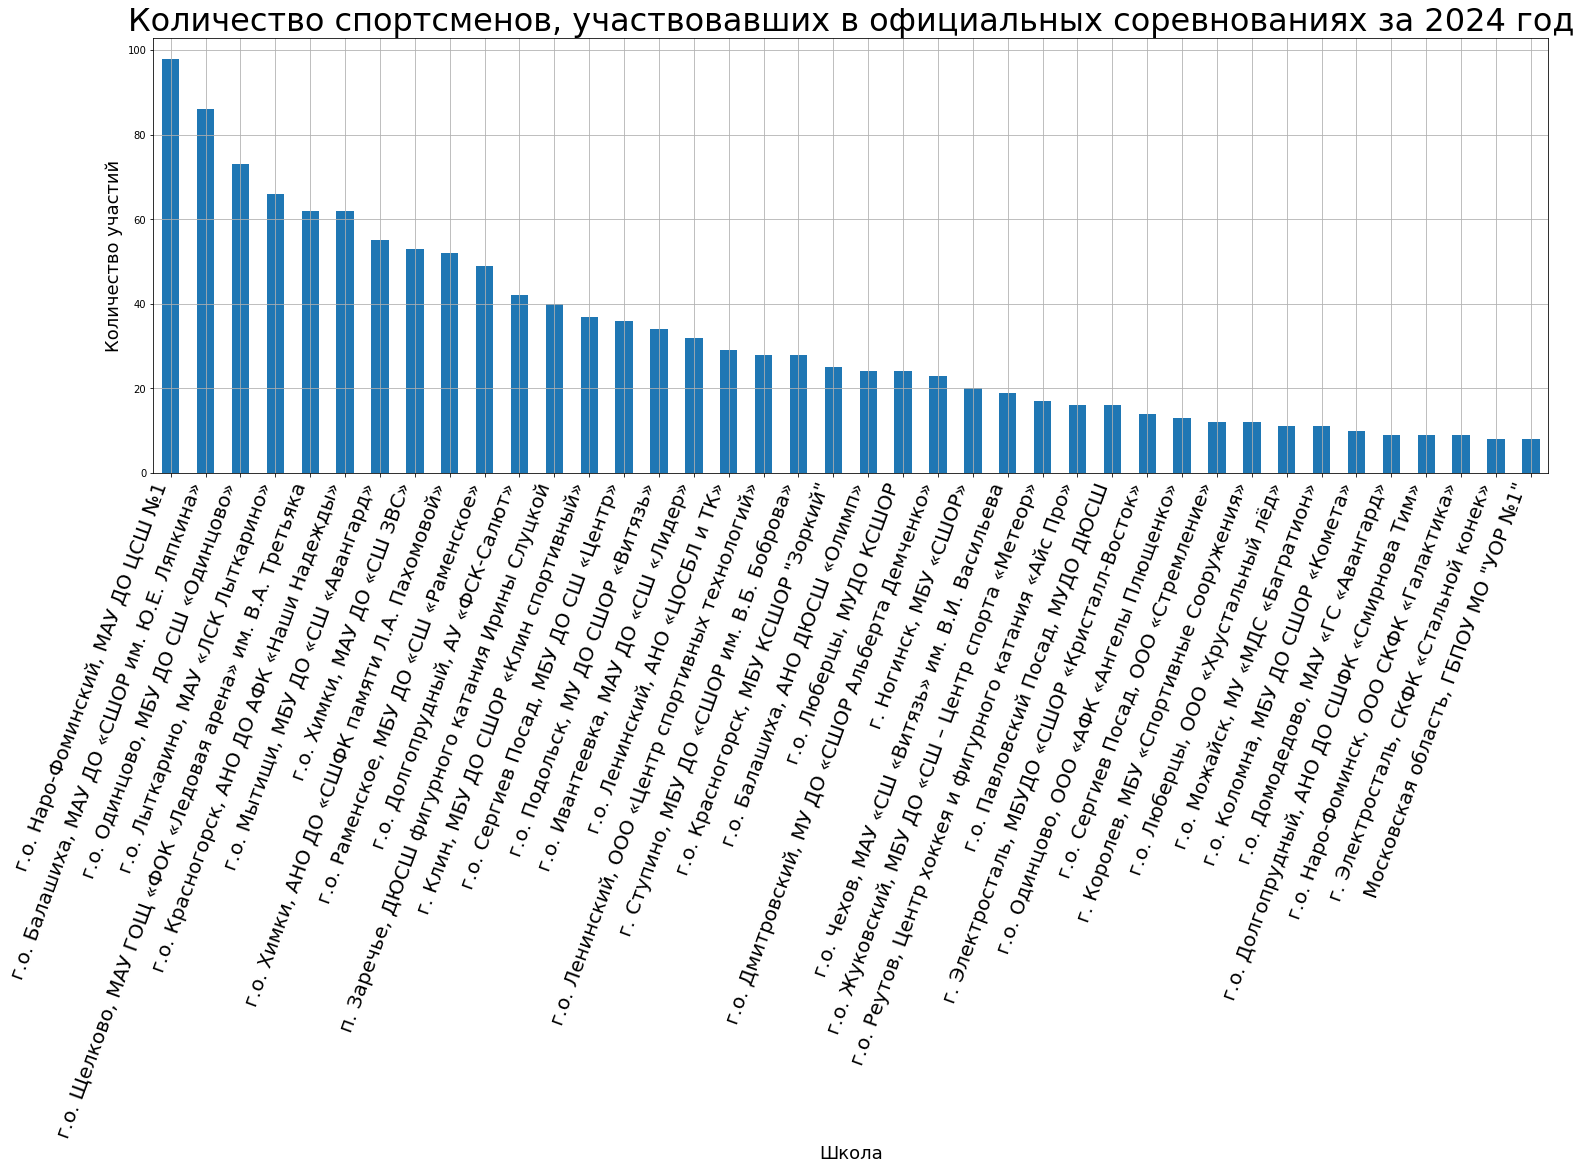

In [731]:
df[df['year'] == 2024].groupby(['club', 'name']).count().groupby('club').count().sort_values(
    by='title', ascending=False)['title'].head(40).plot(
    kind='bar', figsize=(25, 8), grid=True
)
plt.title('Количество спортсменов, участвовавших в официальных соревнованиях за 2024 год', fontsize=32)
plt.xlabel('Школа', fontsize=18)
plt.ylabel('Количество участий', fontsize=18)
plt.xticks(fontsize=20, rotation=70, horizontalalignment='right');

In [736]:

club = 'г.о. Наро-Фоминский, МАУ ДО ЦСШ №1'
club = 'г.о. Балашиха, МАУ ДО «СШОР им. Ю.Е. Ляпкина»'
club = 'г.о. Наро-Фоминск, ООО СКФК «Галактика»'
club = 'г.о. Люберцы, МУДО КСШОР'
year = 2025

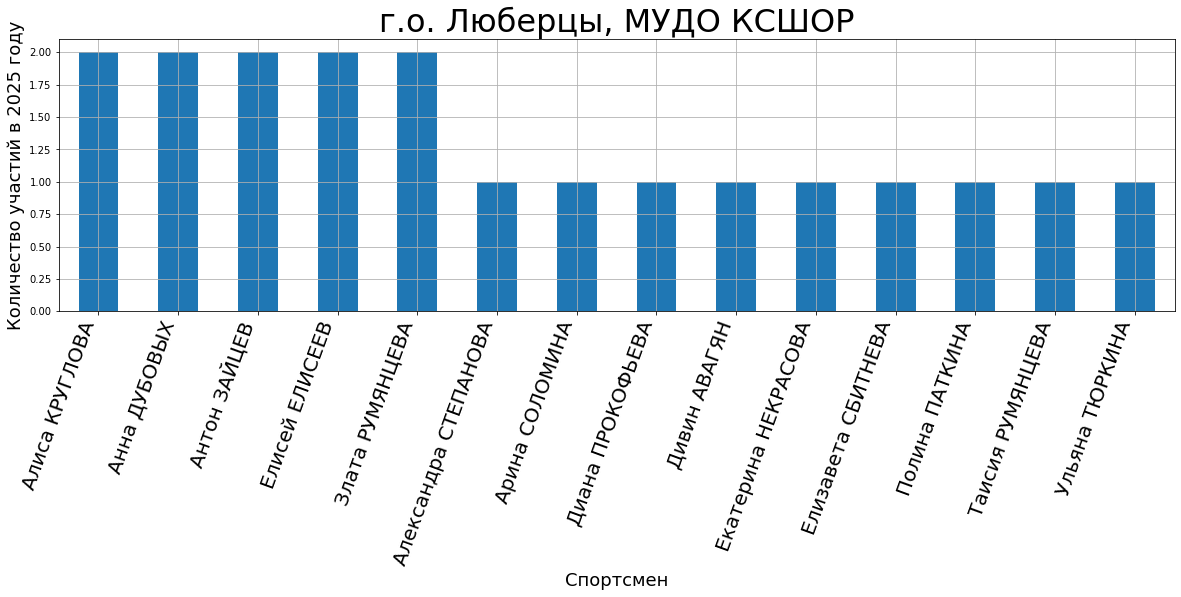

In [737]:
df[(df['year'] == year) & (df['club'] == club)].groupby('name').count().sort_values(
    by='title', ascending=False).head(50)['title'].plot(
    kind='bar', figsize=(20, 5), grid=True
)
plt.title(club, fontsize=32)
plt.xlabel('Спортсмен', fontsize=18)
plt.ylabel(f'Количество участий в {year} году', fontsize=18)
plt.xticks(fontsize=20, rotation=70, horizontalalignment='right');

In [738]:
df[(df['year'] == year) & (df['club'] == club)].sort_values(by='points', ascending=False)

,Unnamed: 0,title,date,place,online_link,category,rank,name,club,points,year
24196,75,Спортивные соревнования Московской области по ...,2025-03-15,"г. Клин, ул. Карла Маркса, д. 99, Ледовый двор...",http://ffkkmo.ru/events/2425/klin1503/,"1 cпopтивный рaзряд, дeвушки",6,Екатерина НЕКРАСОВА,"г.о. Люберцы, МУДО КСШОР",100.71,2025
24197,76,Спортивные соревнования Московской области по ...,2025-03-15,"г. Клин, ул. Карла Маркса, д. 99, Ледовый двор...",http://ffkkmo.ru/events/2425/klin1503/,"1 cпopтивный рaзряд, дeвушки",7,Елизавета СБИТНЕВА,"г.о. Люберцы, МУДО КСШОР",88.38,2025
24175,54,Спортивные соревнования Московской области по ...,2025-03-15,"г. Клин, ул. Карла Маркса, д. 99, Ледовый двор...",http://ffkkmo.ru/events/2425/klin1503/,"2 cпopтивный рaзряд, дeвушки",7,Диана ПРОКОФЬЕВА,"г.о. Люберцы, МУДО КСШОР",75.54,2025
24179,58,Спортивные соревнования Московской области по ...,2025-03-15,"г. Клин, ул. Карла Маркса, д. 99, Ледовый двор...",http://ffkkmo.ru/events/2425/klin1503/,"2 cпopтивный рaзряд, дeвушки",11,Полина ПАТКИНА,"г.о. Люберцы, МУДО КСШОР",73.90,2025
23371,67,Спортивные соревнования Московской области по ...,2025-01-25,г. Красногорск ул. Лесная д.1А Ледовая Арена и...,http://ffkkmo.ru/events/2425/kr01/,"2 cпoртивный рaзряд, юнoши",1,Елисей ЕЛИСЕЕВ,"г.о. Люберцы, МУДО КСШОР",67.54,2025
24168,47,Спортивные соревнования Московской области по ...,2025-03-15,"г. Клин, ул. Карла Маркса, д. 99, Ледовый двор...",http://ffkkmo.ru/events/2425/klin1503/,"2 cпopтивный рaзряд, юнoши",1,Елисей ЕЛИСЕЕВ,"г.о. Люберцы, МУДО КСШОР",62.31,2025
24152,31,Спортивные соревнования Московской области по ...,2025-03-15,"г. Клин, ул. Карла Маркса, д. 99, Ледовый двор...",http://ffkkmo.ru/events/2425/klin1503/,"3 cпopтивный рaзряд, юнoши",1,Антон ЗАЙЦЕВ,"г.о. Люберцы, МУДО КСШОР",35.74,2025
23691,54,Спортивные соревнования Московской области по ...,2025-02-11,"г. Щелково, ул. Фабричная д.4, Ледовая арена и...",http://ffkkmo.ru/events/2425/sh02/,"3 спортивный разряд, юноши",2,Антон ЗАЙЦЕВ,"г.о. Люберцы, МУДО КСШОР",35.66,2025
23682,45,Спортивные соревнования Московской области по ...,2025-02-11,"г. Щелково, ул. Фабричная д.4, Ледовая арена и...",http://ffkkmo.ru/events/2425/sh02/,"3 спopтиный рaзряд, девушки",10,Злата РУМЯНЦЕВА,"г.о. Люберцы, МУДО КСШОР",34.24,2025
24302,97,Спортивные соревнования Московской области по ...,2025-03-18,"г. Щелково, ул. Фабричная, д. 4, ЛД им. В. Тре...",http://ffkkmo.ru/events/2425/sh03/,"3 cпортивный pазpяд, дeвoчки",17,Злата РУМЯНЦЕВА,"г.о. Люберцы, МУДО КСШОР",33.19,2025


In [679]:
df['rank'].value_counts()

1      2365
2      1927
3      1617
4      1430
5      1314
6      1220
7      1157
8      1095
9      1037
10      976
WD      907
11      904
12      851
13      791
14      733
15      677
16      621
17      562
18      509
19      474
20      426
21      389
22      355
23      320
24      284
25      247
26      218
27      187
28      165
29      146
30      120
31       98
32       81
33       70
34       57
35       53
36       45
37       40
38       32
DSQ      31
0        28
39       27
40       24
41       20
43       16
42       16
44       15
45       13
46        9
47        6
48        4
50        3
49        3
FNR       2
Name: rank, dtype: int64

In [404]:
def get_payment_value(total, percentage, period):
    return total * percentage / 12 / (1 - (1 + percentage / 12)**(-period*12))

In [470]:
pv = 600000
kas = 0
dop = 120000
cs55 = 2530000
cs35 = 2210000
car = cs55
perc = 0.19
period = 5
payment_value = get_payment_value(car - pv + kas + dop, perc, period)
print(f"Процент ПВ = {pv / car * 100:0.2f}% - {pv}")
print(f"Платеж = {payment_value}")
print(f"Переплата = {payment_value * period * 12 - car + pv}")

Процент ПВ = 23.72% - 600000
Платеж = 53178.1298415446
Переплата = 1260687.7904926757
